In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Loading the csv as a DataFrame
df = pd.read_csv('shipping.csv', encoding='iso-8859-1')

# Checking the dataframe
# df.info()
# print(df.isna().sum())

In [2]:
# Removing ID from df
df = df.drop(columns=['ï»¿ID'])

# Encoding 'Warehouse_block', 'Mode_of_Shipment', 'Product_importance' and 'Gender'
df = pd.get_dummies(data = df, columns = ['Warehouse_block'], prefix='Warehouse_block_', drop_first = False, dtype = int)
df = pd.get_dummies(data = df, columns = ['Mode_of_Shipment'], prefix='Mode_of_Shipment_', drop_first = False, dtype = int)
df = pd.get_dummies(data = df, columns = ['Product_importance'], prefix='Product_importance_', drop_first = False, dtype = int)
df = pd.get_dummies(data = df, columns = ['Gender'], prefix='Gender_', drop_first = False, dtype = int)

# Encoding 'Warehouse_block', 'Mode_of_Shipment', 'Product_importance' and 'Gender'
# df = pd.get_dummies(data = df, columns = ['Warehouse_block'], prefix='Warehouse_block_', drop_first = True, dtype = int)
# df = pd.get_dummies(data = df, columns = ['Mode_of_Shipment'], prefix='Mode_of_Shipment_', drop_first = True, dtype = int)
# df = pd.get_dummies(data = df, columns = ['Product_importance'], prefix='Product_importance_', drop_first = True, dtype = int)
# df = pd.get_dummies(data = df, columns = ['Gender'], prefix='Gender_', drop_first = True, dtype = int)


# Adding 'cost_of_the_product_per_gram' and 'cost_minus_discount' features
df['cost_of_the_product_per_gram'] = df['Cost_of_the_Product']/df['Weight_in_gms']
df['cost_minus_discount'] = df['Cost_of_the_Product']-df['Discount_offered']

In [3]:
# df.info()
# df

#Scaling

In [4]:
sc = StandardScaler()
columns_to_scale = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'cost_of_the_product_per_gram', 'cost_minus_discount']
df[columns_to_scale] = sc.fit_transform(df[columns_to_scale])
# df

# Correlations

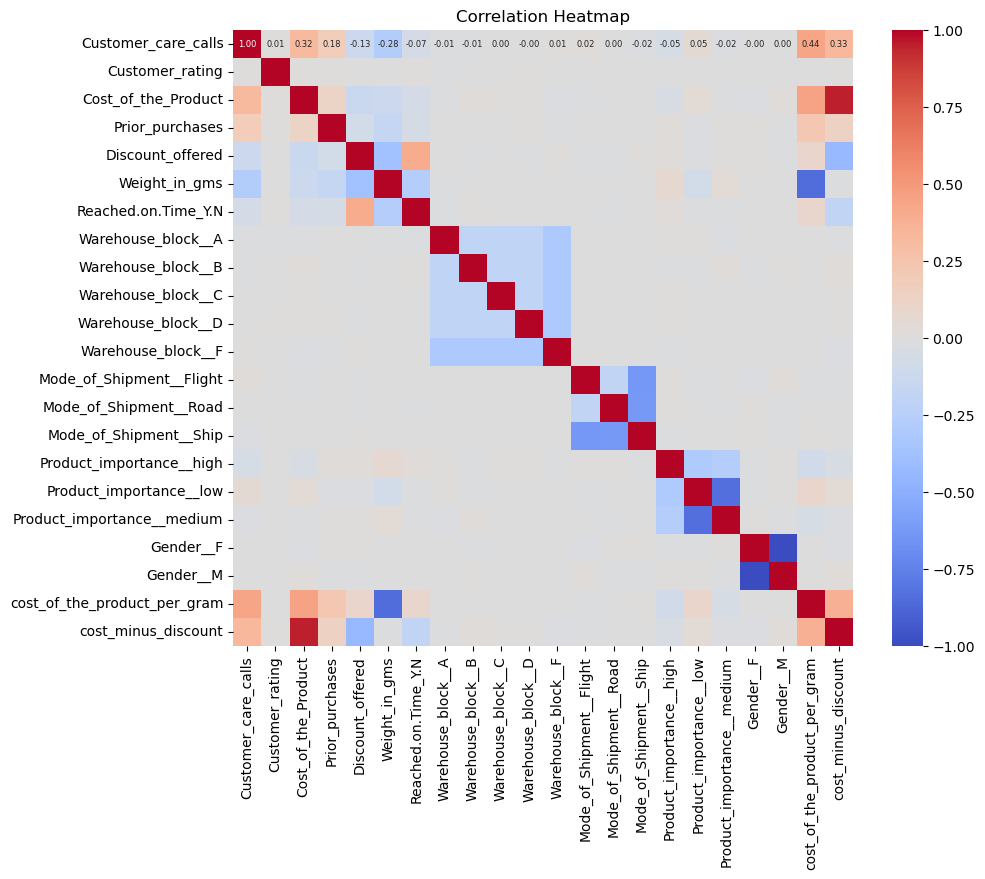

In [5]:
correlation_matrix = df.corr()
correlation_matrix = correlation_matrix.round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", annot=True, annot_kws={"fontsize": 6})
plt.title('Correlation Heatmap')
plt.show()

# Classification

In [6]:
y = df['Reached.on.Time_Y.N']
X = df.drop(columns = 'Reached.on.Time_Y.N')
np.random.seed(77300)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8799, 21)
(2200, 21)
(8799,)
(2200,)


In [7]:
# First we define a set of functions to compute the metrics of the model

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

#FPR
def custom_FPR_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (fp/(fp+tn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

# Best model search via GridSearch

In [8]:
LR_params = {'penalty' : ['l1', 'l2', 'elasticnet', None],
             'dual' : [True, False],
             'C' : [0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3],
             'fit_intercept' : [True, False],
             'intercept_scaling' : [0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3],
             'max_iter': [100, 200, 300],
             'warm_start' : [True, False],
             'l1_ratio' : [0.1, 0.2, 0.3, 0.5, 0.7, 1],
             'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
             'multi_class' : ['auto', 'ovr', 'multinomial']}

DT_params = {'max_leaf_nodes': range(1,25),
             'criterion' : ['gini', 'entropy', 'log_loss'],
             'splitter' : ['best', 'random']}

RF_params = {'n_estimators': [175, 200, 225, 250, 275, 300],
             'criterion' : ['gini', 'entropy', 'log_loss'],
             'max_features' : ['sqrt', 'log2', None],
             'bootstrap' : [True, False],
             'oob_score' : [True, False],
             'warm_start' : [True, False]}

GBC_params = {'n_estimators': [10, 25, 50, 100, 150, 200, 250],
              'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'loss' : ['log_loss', 'exponential'],
              'subsample' : [0.1, 0.2, 0.3, 0.5, 0.7, 1],
              'criterion' : ['friedman_mse', 'squared_error'],
              'max_depth' : [ 3, 4, 5, 6, 7, 8],
              'warm_start' : [True, False]}

SVM_params = {'C': [0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
              'gamma': ['scale', 'auto'],
              'probability' : [True, False],
              'decision_function_shape' : ['ovo', 'ovr'],
              'break_ties' : [True, False]}

model_params = {
#    'logistic_regression' : {
#        'model': LogisticRegression(random_state=42),
#        'params': LR_params
#    }
#    ,
#    'decision_tree' : {
#       'model': DecisionTreeClassifier(random_state=42),
#       'params': DT_params
#    }
#    ,
#    'random_forest': {
#       'model': RandomForestClassifier(random_state=42),
#       'params': RF_params
#    }
#    ,
    'gradient_boost': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': GBC_params
    }
#    ,
#    'svm': {
#        'model': SVC(random_state=42),
#        'params' : SVM_params
#    }
}

In [9]:
# Hyper-parameter tuning using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)
scores = []

for model_name, mp in model_params.items():
    classifier =  GridSearchCV(estimator = mp['model'], param_grid = mp['params'], cv=5, scoring = score_func, return_train_score=True, verbose = 3.5)
    classifier.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_
    })

best_model = pd.DataFrame(scores, columns=['model','best_score','best_params'])
pd.set_option('display.max_colwidth', None)
best_model.head()

Fitting 5 folds for each of 8064 candidates, totalling 40320 fits
[CV 1/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=10, subsample=0.1, warm_start=True;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=10, subsample=0.1, warm_start=True;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=10, subsample=0.1, warm_start=True;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=10, subsample=0.1, warm_start=True;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 5/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=10, subsample=0.1, warm_start=True;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 

[CV 5/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=10, subsample=0.7, warm_start=True;, score=(train=0.500, test=0.500) total time=   0.1s
[CV 1/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=10, subsample=0.7, warm_start=False;, score=(train=0.500, test=0.500) total time=   0.1s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=10, subsample=0.7, warm_start=False;, score=(train=0.500, test=0.500) total time=   0.1s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=10, subsample=0.7, warm_start=False;, score=(train=0.500, test=0.500) total time=   0.1s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=10, subsample=0.7, warm_start=False;, score=(train=0.500, test=0.500) total time=   0.1s
[CV 5/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_

[CV 5/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=25, subsample=0.3, warm_start=False;, score=(train=0.500, test=0.500) total time=   0.1s
[CV 1/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=25, subsample=0.5, warm_start=True;, score=(train=0.500, test=0.500) total time=   0.2s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=25, subsample=0.5, warm_start=True;, score=(train=0.500, test=0.500) total time=   0.2s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=25, subsample=0.5, warm_start=True;, score=(train=0.500, test=0.500) total time=   0.2s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=3, n_estimators=25, subsample=0.5, warm_start=True;, score=(train=0.500, test=0.500) total time=   0.2s
[CV 5/5] END criterion=friedman_mse, learning_rate=0.01, loss=log_los

KeyboardInterrupt: 

In [9]:
model = DecisionTreeClassifier(random_state = 42, max_leaf_nodes = 8).fit(X_train, y_train)


classification_threshold_range = [x / 100 for x in range(0, 101, 1)]
threshold_list = []


# class_threshold = ((df['Reached.on.Time_Y.N'] == 0).sum())/((df['Reached.on.Time_Y.N'] == 1).sum()+(df['Reached.on.Time_Y.N'] == 1).sum())

for i in classification_threshold_range:
  y_pred_prob = model.predict_proba(X_test)[:,1] # probabilities
  y_pred = np.where(y_pred_prob > i, 1, 0)
  accuracy = custom_accuracy_score(y_test, y_pred)
  sensitivity = custom_sensitivity_score(y_test, y_pred)
  specificity = custom_specificity_score(y_test, y_pred)
  ppv = custom_ppv_score(y_test, y_pred)
  npv = custom_npv_score(y_test, y_pred)
  threshold_list.append([i, accuracy, sensitivity, specificity, ppv, npv])

#threshold_list.append()

threshold_list


C:\Users\Aftershock\AppData\Local\Temp\ipykernel_28004\4052962060.py:53: RuntimeWarning: invalid value encountered in scalar divide
  return (tn/(tn+fn))
C:\Users\Aftershock\AppData\Local\Temp\ipykernel_28004\4052962060.py:53: RuntimeWarning: invalid value encountered in scalar divide
  return (tn/(tn+fn))
C:\Users\Aftershock\AppData\Local\Temp\ipykernel_28004\4052962060.py:53: RuntimeWarning: invalid value encountered in scalar divide
  return (tn/(tn+fn))
C:\Users\Aftershock\AppData\Local\Temp\ipykernel_28004\4052962060.py:53: RuntimeWarning: invalid value encountered in scalar divide
  return (tn/(tn+fn))
C:\Users\Aftershock\AppData\Local\Temp\ipykernel_28004\4052962060.py:53: RuntimeWarning: invalid value encountered in scalar divide
  return (tn/(tn+fn))
C:\Users\Aftershock\AppData\Local\Temp\ipykernel_28004\4052962060.py:53: RuntimeWarning: invalid value encountered in scalar divide
  return (tn/(tn+fn))
C:\Users\Aftershock\AppData\Local\Temp\ipykernel_28004\4052962060.py:53: Run

[[0.0, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.01, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.02, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.03, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.04, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.05, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.06, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.07, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.08, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.09, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.1, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.11, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.12, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.13, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.14, 0.5968181818181818, 1.0, 0.0, 0.5968181818181818, nan],
 [0.15, 0.5968181818181818, 1.0, 0.0, 0.59

In [12]:
max_accuracy = max_sensitivity = max_specificity = max_ppv = max_npv = float('-inf')  # Initialize with negative infinity to ensure any value will be greater

for row in threshold_list:
    if row[1] > max_accuracy:
        max_accuracy = row[1]
        accuracy_threshold = row[0]
    if row[2] > max_sensitivity:
        max_sensitivity = row[2]
        sensitivity_threshold = row[0]
    if row[3] > max_specificity:
        max_specificity = row[3]
        specificity_threshold = row[0]
    if row[4] > max_ppv:
        max_ppv = row[4]
        ppv_threshold = row[0]
    if row[5] > max_npv:
        max_npv = row[5]
        npv_threshold = row[0]

print("Maximum accuracy:", max_accuracy, ", Threshold: ", accuracy_threshold)
print("Maximum sensitivity:", max_sensitivity, ", Threshold: ", sensitivity_threshold)
print("Maximum specificity:", max_specificity, ", Threshold: ", specificity_threshold)
print("Maximum ppv:", max_ppv, ", Threshold: ", ppv_threshold)
print("Maximum npv:", max_npv, ", Threshold: ", npv_threshold)

Maximum accuracy: 0.6909090909090909 , Threshold:  0.55
Maximum sensitivity: 1.0 , Threshold:  0.0
Maximum specificity: 1.0 , Threshold:  0.9
Maximum ppv: 1.0 , Threshold:  0.9
Maximum npv: 0.5876010781671159 , Threshold:  0.43


In [13]:
y_pred_prob = model.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > 0.55, 1, 0)

print(y_pred_prob)
print(y_pred)

[0.42767437 0.42767437 1.         ... 0.44867437 0.44867437 0.44867437]
[0 0 1 ... 0 0 0]


Metrics of the model: 

Confusion matrix: 
[643, 10]
[670, 877]
                                   Accuracy: 0.6909090909090909
                   SENSITIVITY (aka RECALL): 0.4897182025894897
                 SPECIFICITY (aka FALL-OUT): 0.9887260428410372
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9846860643185299
                 NEGATIVE PREDICTIVE VALUE): 0.5669036845507434


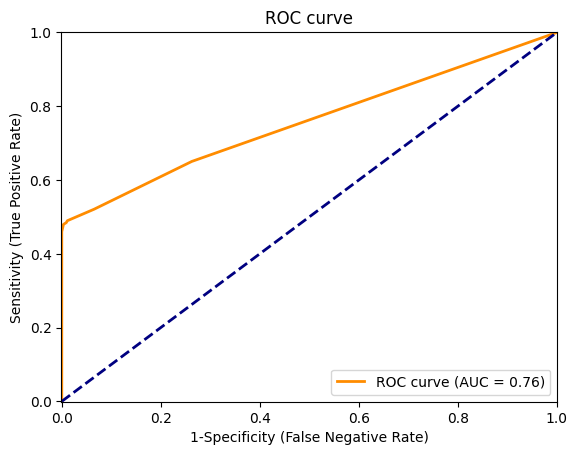

 Optimal threshold:  0.6153846153846154
 AUC: 0.7567435522495967


In [14]:
print('Metrics of the model: \n')

cm_1 = [confusion_matrix(y_test, y_pred)[1][1],confusion_matrix(y_test, y_pred)[0][1]]
cm_2 = [confusion_matrix(y_test, y_pred)[1][0],confusion_matrix(y_test, y_pred)[0][0]]
print("Confusion matrix: \n" + str(cm_1) + "\n" + str(cm_2))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

# Logistic regression

In [16]:
# define the model and call it classifier_LR
classifier_LR = LogisticRegression(solver='liblinear', random_state = 42)

# train classifier_LR on the training data
classifier_LR.fit(X_train, y_train)

# This is a regression, so it has coefficients -- lets see them
# Note, there is no easy way to show significance, etc. with sklearn
print('Intercept: ' + str(classifier_LR.intercept_))
print('Coefficients (15 in descending order): ')
summary = pd.DataFrame([X_test.columns,classifier_LR.coef_[0]]).transpose().sort_values(by = 1, ascending = False)
summary.columns = ['Variable','Coefficient']
desc15list = summary.head(15) # all 15 features in descending order
# desc15list

Intercept: [0.4228157]
Coefficients (15 in descending order): 


In [17]:
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]

y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # applying the threshold rule to classify

print(y_pred_prob[0:5]) # first 5 probabilities
print(y_pred[0:5]) # resultant predicted classification
print(y_test[0:5])

[0.4637402  0.27899027 0.56710057 0.51157236 0.5031263 ]
[0 0 1 0 0]
9108    0
3832    1
469     1
5686    1
6083    0
Name: Reached.on.Time_Y.N, dtype: int64


In [18]:
# (df['Reached.on.Time_Y.N'] == 1).sum()
# (df['Reached.on.Time_Y.N'] == 0).sum()

Metrics of the logistic regression model: 

Confusion matrix: 
[856, 280]
[457, 607]
                                   Accuracy: 0.665
                   SENSITIVITY (aka RECALL): 0.6519421172886519
                                       FPR : 0.3156708004509583
                 SPECIFICITY (aka FALL-OUT): 0.6843291995490417
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.7535211267605634
                 NEGATIVE PREDICTIVE VALUE): 0.5704887218045113


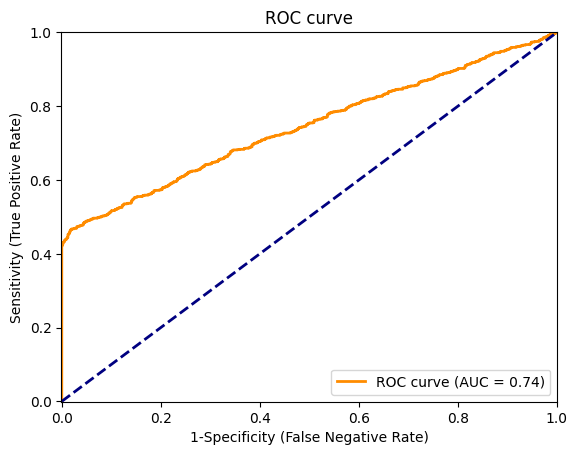

 Optimal threshold:  0.6788697558753257
 AUC: 0.7434131497444255


In [19]:
# Lets look at the model metrics
print('Metrics of the logistic regression model: \n')

cm_1 = [confusion_matrix(y_test, y_pred)[1][1],confusion_matrix(y_test, y_pred)[0][1]]
cm_2 = [confusion_matrix(y_test, y_pred)[1][0],confusion_matrix(y_test, y_pred)[0][0]]
print("Confusion matrix: \n" + str(cm_1) + "\n" + str(cm_2))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                                       FPR : " + str(custom_FPR_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [14]:
# Apply variable selection with Stepwise Recursive Feature Selection

from sklearn.feature_selection import RFE

rfe = RFE(estimator=classifier_LR, n_features_to_select=10, step=1) # in this example we will select 3 variables; this number "3" is a hyperparameter to tune
rfe.fit(X_train, y_train)
ranking = rfe.ranking_.reshape(len(X_train.columns))

# which 3 variables are in the model?
pd.DataFrame([X_test.columns,ranking]).transpose().sort_values(1).head(15)

,0,1
20,cost_minus_discount,1
18,Gender__M,1
2,Cost_of_the_Product,1
4,Discount_offered,1
5,Weight_in_gms,1
17,Gender__F,1
14,Product_importance__high,1
13,Mode_of_Shipment__Ship,1
12,Mode_of_Shipment__Road,1
19,cost_of_the_product_per_gram,1


Metrics of the logistic regression model after variable selection: 

Confusion matrix: 
[857, 279]
[456, 608]
                                   Accuracy: 0.6659090909090909
                   SENSITIVITY (aka RECALL): 0.6527037319116527
                 SPECIFICITY (aka FALL-OUT): 0.685456595264938
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.7544014084507042
                 NEGATIVE PREDICTIVE VALUE): 0.5714285714285714


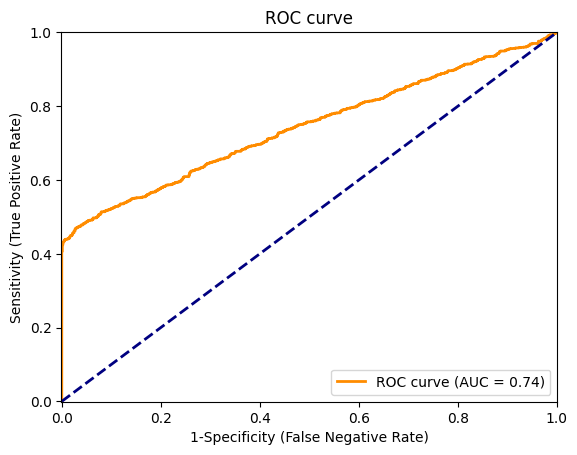

 Optimal threshold:  0.6726015320223647
 AUC: 0.7430422168051511


In [15]:
# Train the model and call it classifier_LR_RFE
classifier_LR_RFE = rfe.fit(X_train, y_train)

# Use the trained model to predict testing data
y_pred_prob = classifier_LR_RFE.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification


# Lets look at the model metrics after variable selection
print('Metrics of the logistic regression model after variable selection: \n')

cm_1 = [confusion_matrix(y_test, y_pred)[1][1],confusion_matrix(y_test, y_pred)[0][1]]
cm_2 = [confusion_matrix(y_test, y_pred)[1][0],confusion_matrix(y_test, y_pred)[0][0]]
print("Confusion matrix: \n" + str(cm_1) + "\n" + str(cm_2))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [16]:
# AUC: 0.7434449194637616

# Classification and Regression Tree, CART

In [17]:
# Define a CART model and call it classifier_DT
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 10, random_state=77300) # random_state -- is same as random seed, neede to get the same result every time we rerun

# Train the model classifier_DT on the training data
classifier_DT.fit(X_train, y_train)

#  Use the trained model to predict testing data
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print(y_pred_prob[0:5]) # first 5 probabilities
print(y_pred[0:5]) # resultant predicted classification
print(y_test[0:5]) # actual outcomes

# WOW -- the CART model made no mistakes on the first 5 customers!

[0.42767437 0.42767437 1.         0.42767437 0.42767437]
[0 0 1 0 0]
9108    0
3832    1
469     1
5686    1
6083    0
Name: Reached.on.Time_Y.N, dtype: int64


CART tree with 15 leafs


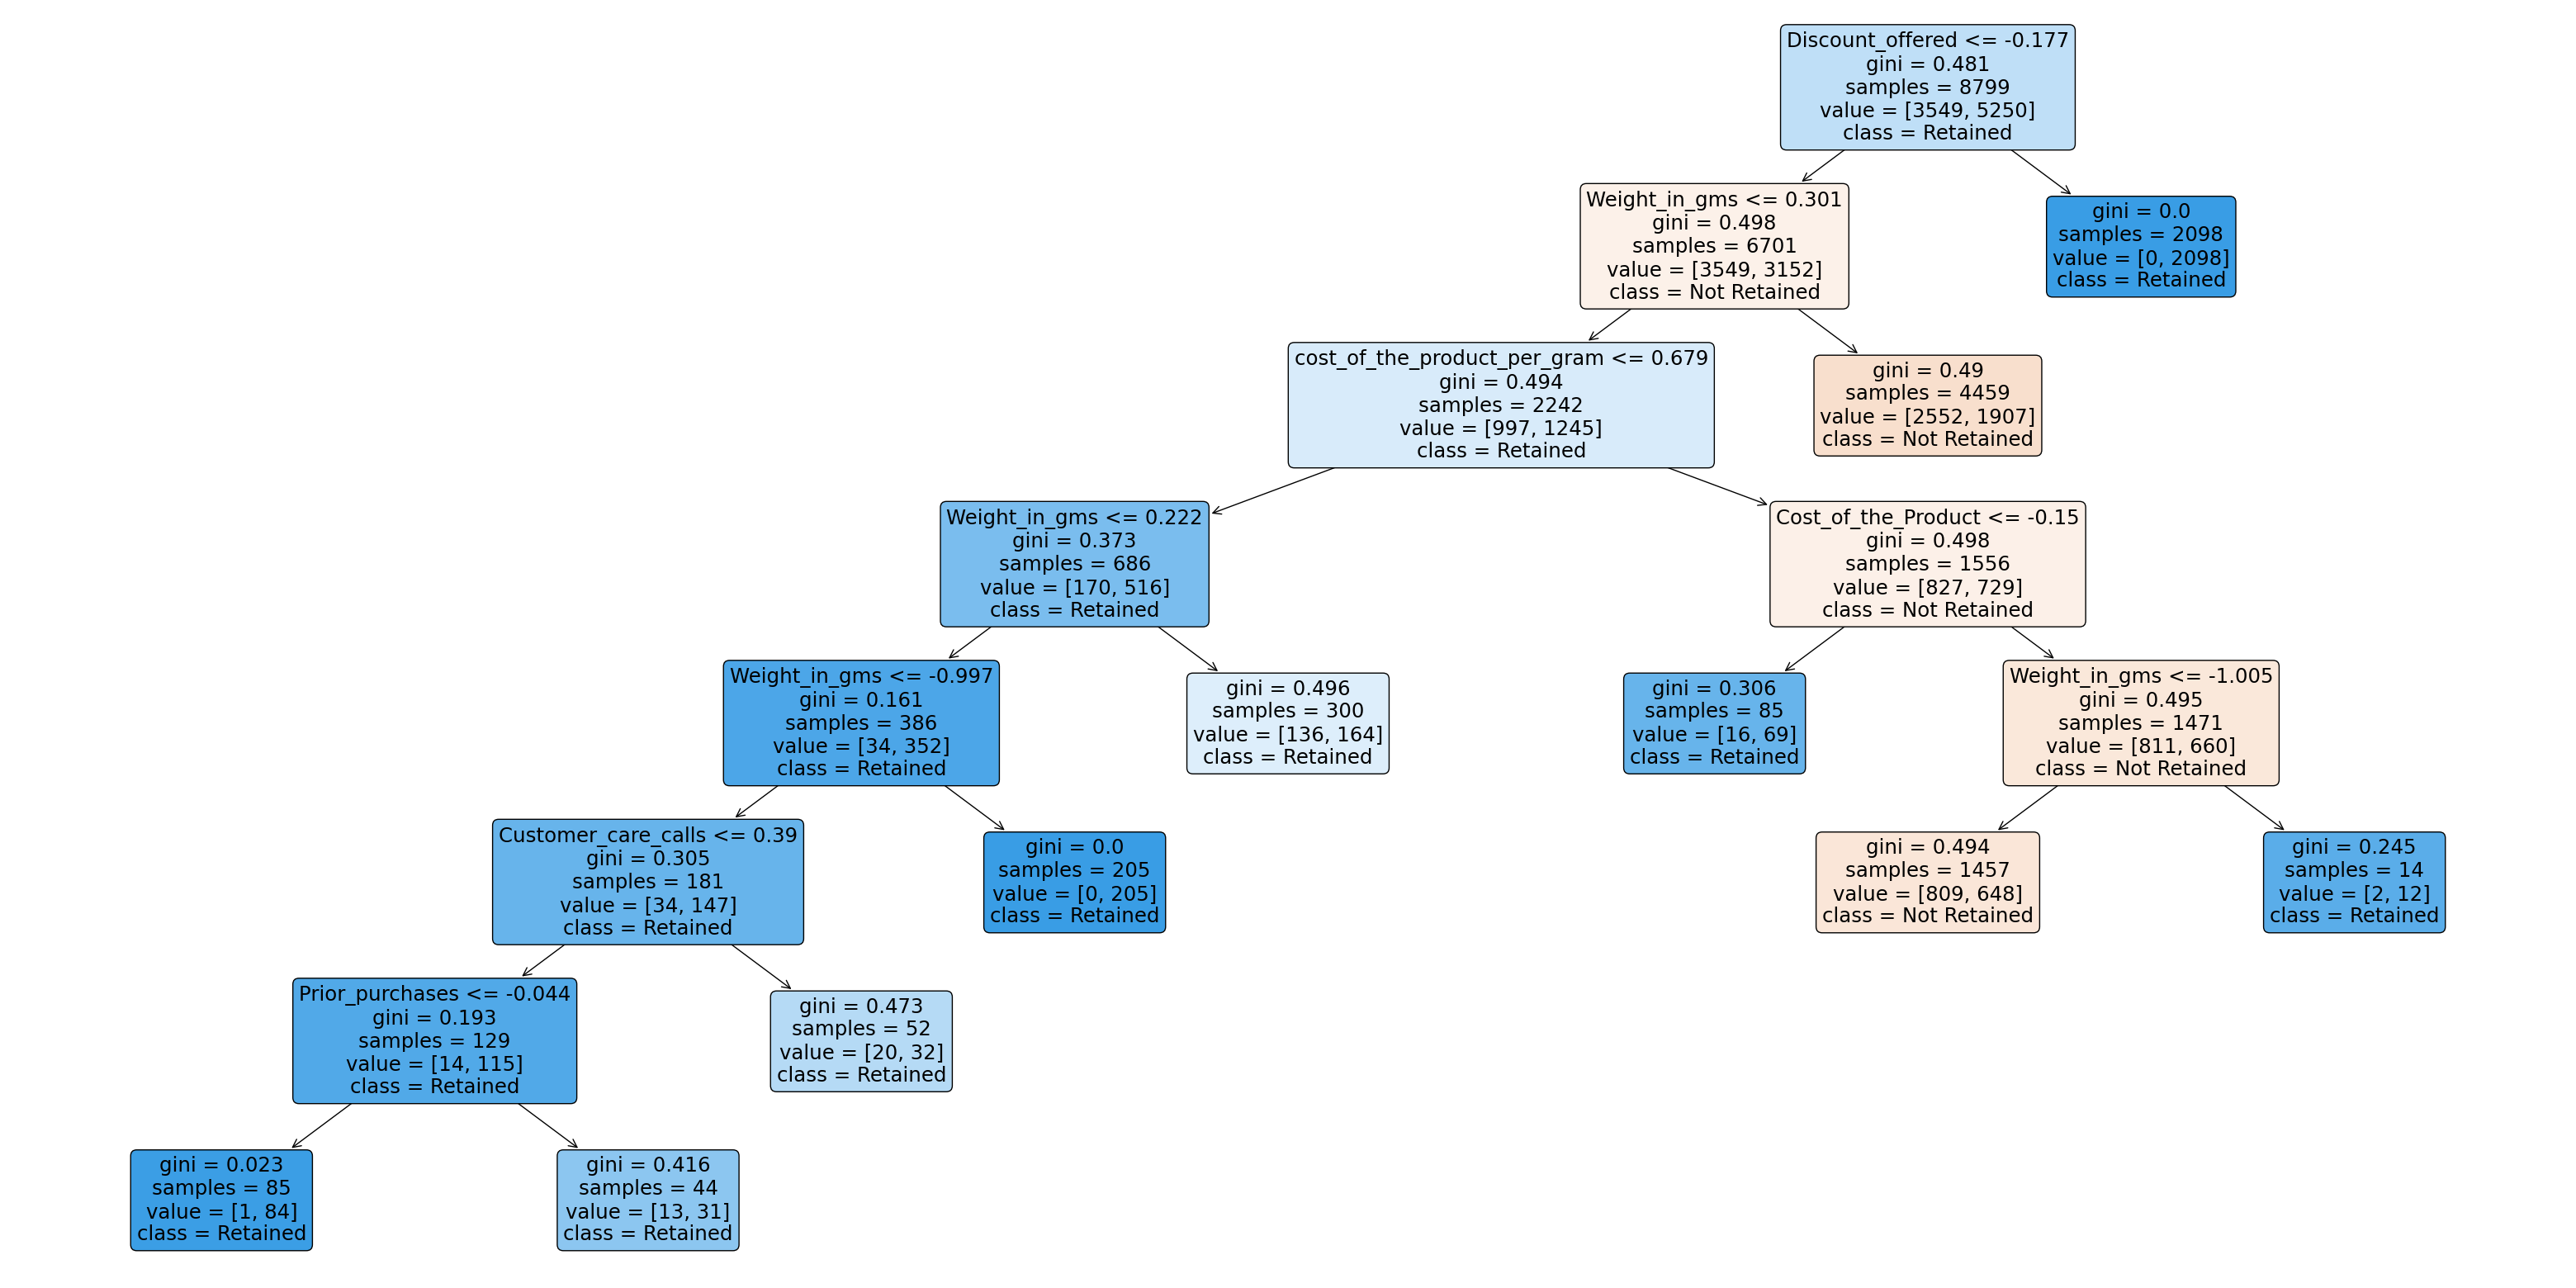

In [18]:
# Visualizing the resultant tree

from sklearn import tree

plt.figure(figsize=(40,20))
tree.plot_tree(classifier_DT.fit(X_train, y_train), feature_names = X_train.columns, filled = True,
               class_names = ['Not Retained', 'Retained'], rounded = True)
print('CART tree with 15 leafs')

Metrics of the CART model: 

Confusion matrix: 
[687, 59]
[626, 828]
                                   Accuracy: 0.6886363636363636
                   SENSITIVITY (aka RECALL): 0.5232292460015232
                 SPECIFICITY (aka FALL-OUT): 0.9334836527621195
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.920911528150134
                 NEGATIVE PREDICTIVE VALUE): 0.5694635488308115


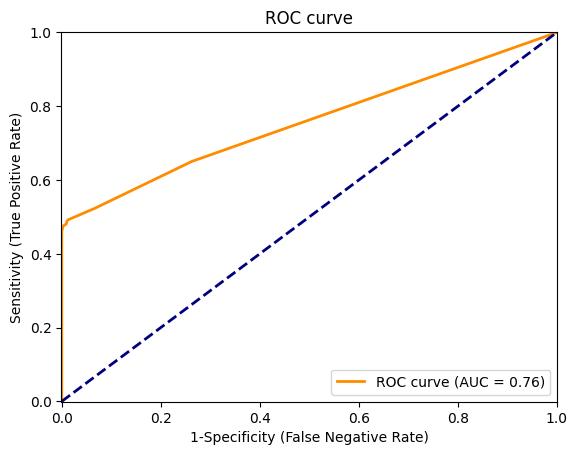

 Optimal threshold:  0.6153846153846154
 AUC: 0.756958641835912


In [19]:
# Lets look at the model metrics

print('Metrics of the CART model: \n')

cm_1 = [confusion_matrix(y_test, y_pred)[1][1],confusion_matrix(y_test, y_pred)[0][1]]
cm_2 = [confusion_matrix(y_test, y_pred)[1][0],confusion_matrix(y_test, y_pred)[0][0]]
print("Confusion matrix: \n" + str(cm_1) + "\n" + str(cm_2))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [20]:
# AUC: 0.7483074038042951

In [21]:
# Hyper-parameter tuning. A CART model has multiple hyper-parameters, for instance:
# -- max number of leaves on a tree,
# -- min number of datapoints at a leaf
# -- min number of datapoints to create a split
# and so on

print(DecisionTreeClassifier().get_params()) # display what those hyper-parameters are and their default values

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


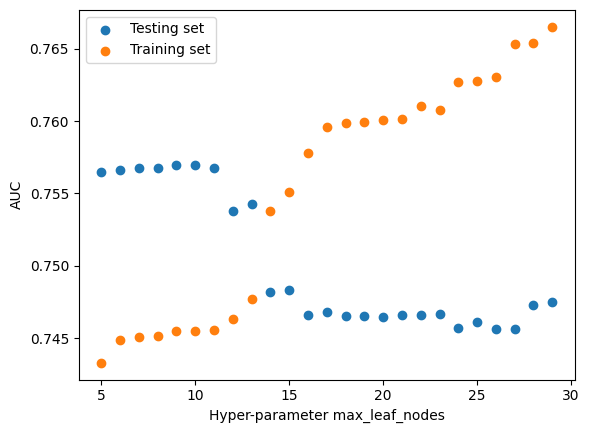

In [22]:
# Tuning hyper-parameter max_leaf_nodes

n_max_leaf_nodes = range(5,30) # Lets train the models with 5, 6, 7, ... 40 leafs

# for each model calculate AUC for testing
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)

    y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_test, y_pred_prob)])

# plot the testing set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# now for each model calculate AUC on training
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)

    y_pred_prob = classifier_DT.predict_proba(X_train)[:,1]
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_train, y_pred_prob)])

# plot the training set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# label the axes on the plot
plt.xlabel('Hyper-parameter max_leaf_nodes')
plt.ylabel('AUC')

# add the legend
plt.legend(['Testing set','Training set'])

In [23]:
# lets train the model with 20 leafs
classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = 13)
classifier_DT = classifier_DT.fit(X_train, y_train)

# obtain its predictions
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

# calclate and print the AUC
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

 AUC: 0.7542599329744786


# Random Forest

In [25]:
# Define a random forest model and call it classifier_RF
classifier_RF = RandomForestClassifier(random_state=77300) # recall what random_state mean

# Train the model classifier_RF on the training data
classifier_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=77300)

Metrics of the Random Forest model: 

Confusion matrix: 
[765, 170]
[548, 717]
                                   Accuracy: 0.6736363636363636
                   SENSITIVITY (aka RECALL): 0.5826351865955827
                 SPECIFICITY (aka FALL-OUT): 0.8083427282976324
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8181818181818182
                 NEGATIVE PREDICTIVE VALUE): 0.566798418972332


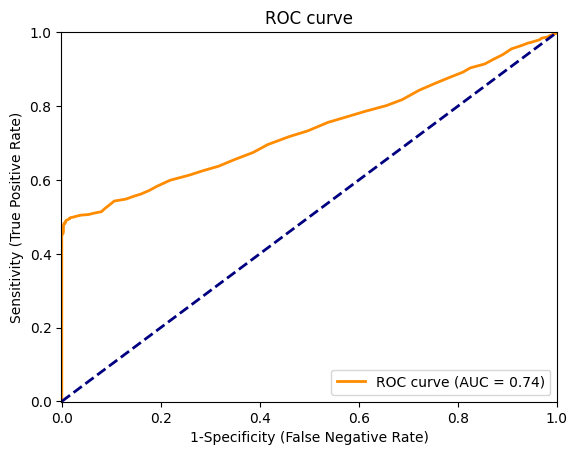

 Optimal threshold:  0.73
 AUC: 0.7354586989355426


In [26]:
# Use the trained model to predict testing data
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Random Forest model: \n')

cm_1 = [confusion_matrix(y_test, y_pred)[1][1],confusion_matrix(y_test, y_pred)[0][1]]
cm_2 = [confusion_matrix(y_test, y_pred)[1][0],confusion_matrix(y_test, y_pred)[0][0]]
print("Confusion matrix: \n" + str(cm_1) + "\n" + str(cm_2))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [27]:
print(classifier_RF.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 77300, 'verbose': 0, 'warm_start': False}


Optimized hyper-parameters:{'n_estimators': 200}
Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": 

Confusion matrix: 
[767, 160]
[546, 727]
                                   Accuracy: 0.6790909090909091
                   SENSITIVITY (aka RECALL): 0.5841584158415841
                 SPECIFICITY (aka FALL-OUT): 0.8196166854565953
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8274002157497303
                 NEGATIVE PREDICTIVE VALUE): 0.5710919088766693


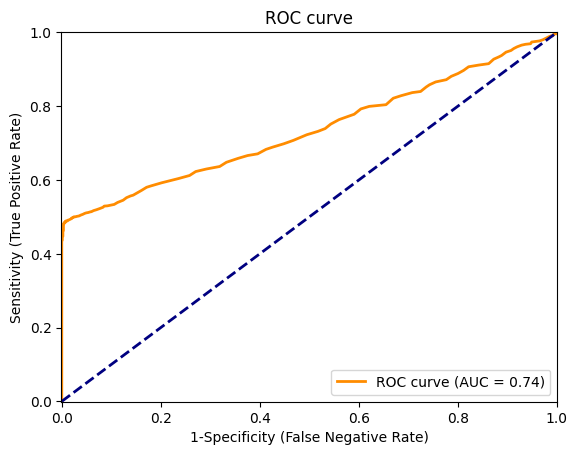

 Optimal threshold:  0.72
 AUC: 0.7350890539578628


In [28]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

n_trees = [25, 50, 75, 100, 125, 150, 175, 200] # as an example, we will tune the "numeber of trees" hyper-parameter (n_trees)

Grid_srch_parameters_list = [ [{'n_estimators':n_trees}] ]

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_RF, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True)

# apply function grid_search to the training data, call the resultand best model grid_search_RF
grid_search_RF = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data
y_pred_prob = grid_search_RF.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))

# Lets look at the model metrics

print('Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": \n')

cm_1 = [confusion_matrix(y_test, y_pred)[1][1],confusion_matrix(y_test, y_pred)[0][1]]
cm_2 = [confusion_matrix(y_test, y_pred)[1][0],confusion_matrix(y_test, y_pred)[0][0]]
print("Confusion matrix: \n" + str(cm_1) + "\n" + str(cm_2))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

<Axes: title={'center': 'Feature Importance'}>

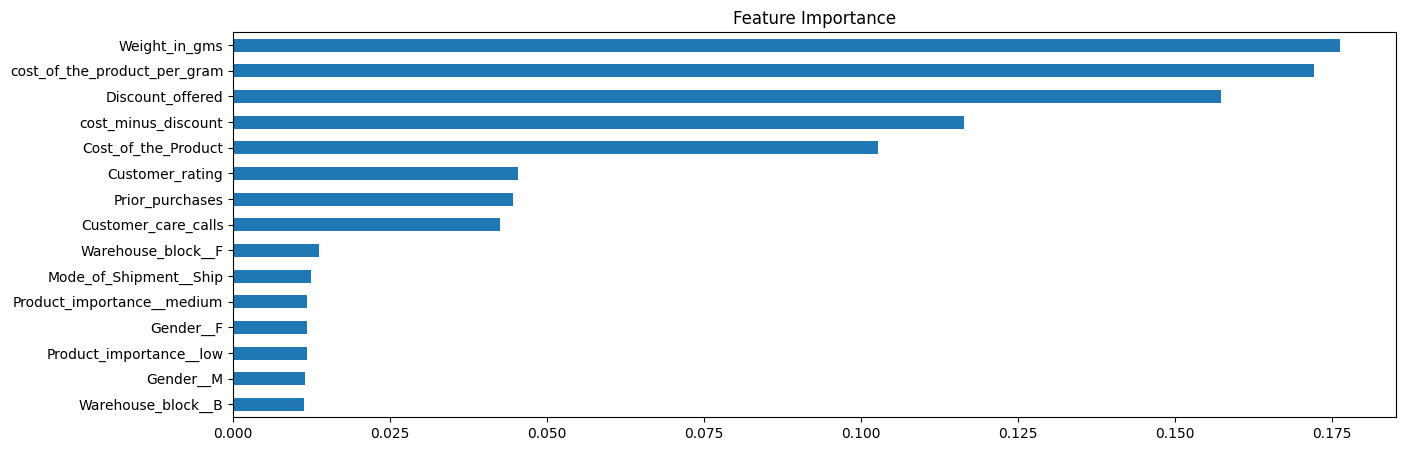

In [29]:
# Tree models do not have coefficients, but have easily-interpretable tree plots
# But in tree ensembles (such as random forect) there is no point to look at individual trees

# Useful intuition, however, can be obtained from the Feature Importance Plots

# calculate feature importances
importances = grid_search_RF.best_estimator_.feature_importances_

# plot them
plt.figure(figsize=(15,5))
plt.title('Feature Importance')
plt.xlabel('Decrease in Gini (recal, Gini = 2*AUC-1)')
feature_importances = pd.Series(classifier_RF.feature_importances_, index=X_train.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')

# Gradient Boosting Machine

In [30]:
# Define the gradient boosting machine model and call it classifier_GBM
classifier_GBM = GradientBoostingClassifier(random_state=77300)

# Train the model classifier_GBM on the training data
classifier_GBM.fit(X_train, y_train)

# A gradient boosting model has many hyper-parameters, for example::
# -- the number of trees in the forest ensemble,
# -- speed of boosting ("learning rate", "decay rate"),
# -- max number of leafs on each tree,
# -- min number of datapoints at a leaf
# and so on

print(classifier_GBM.get_params())

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 77300, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


Metrics of the Gradient Boosting Machine model: 

Confusion matrix: 
[683, 67]
[630, 820]
                                   Accuracy: 0.6831818181818182
                   SENSITIVITY (aka RECALL): 0.5201827875095202
                 SPECIFICITY (aka FALL-OUT): 0.9244644870349493
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9106666666666666
                 NEGATIVE PREDICTIVE VALUE): 0.5655172413793104


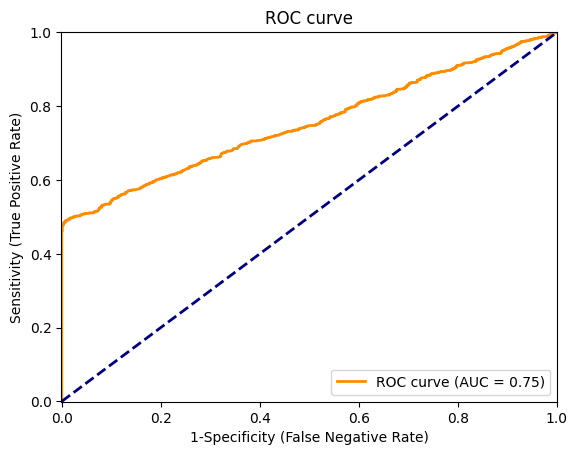

 Optimal threshold:  0.7177513641732058
 AUC: 0.7527779184995076


In [31]:
# Use the trained model to predict testing data
y_pred_prob = classifier_GBM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model: \n')

cm_1 = [confusion_matrix(y_test, y_pred)[1][1],confusion_matrix(y_test, y_pred)[0][1]]
cm_2 = [confusion_matrix(y_test, y_pred)[1][0],confusion_matrix(y_test, y_pred)[0][0]]
print("Confusion matrix: \n" + str(cm_1) + "\n" + str(cm_2))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

Optimized hyper-parameters:{'learning_rate': 0.1, 'n_estimators': 25}
Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": 

Confusion matrix: 
[671, 54]
[642, 833]
                                   Accuracy: 0.6836363636363636
                   SENSITIVITY (aka RECALL): 0.511043412033511
                 SPECIFICITY (aka FALL-OUT): 0.939120631341601
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9255172413793104
                 NEGATIVE PREDICTIVE VALUE): 0.5647457627118644


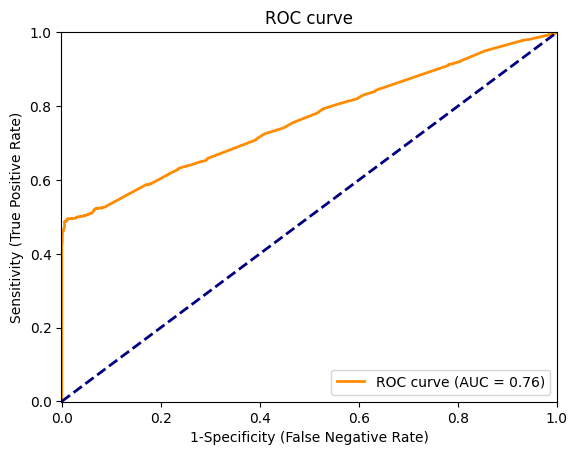

 Optimal threshold:  0.6317781978525672
 AUC: 0.7622070853343247


In [32]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# as an example, we will tune two parameters
n_trees = [10, 25, 50, 100, 150] # first, the "numeber of trees" hyper-parameter (n_trees)
learning_rates = [0.01, 0.1, 0.2, 0.3] # second, speed of boosting ("learning rate")

Grid_srch_parameters_list = [ [{'n_estimators':n_trees, 'learning_rate': learning_rates}] ]

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_GBM, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True)

# # apply function grid_search to the training data, call the resultant best model grid_search_GBM
grid_search_GBM = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data
y_pred_prob = grid_search_GBM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": \n')

cm_1 = [confusion_matrix(y_test, y_pred)[1][1],confusion_matrix(y_test, y_pred)[0][1]]
cm_2 = [confusion_matrix(y_test, y_pred)[1][0],confusion_matrix(y_test, y_pred)[0][0]]
print("Confusion matrix: \n" + str(cm_1) + "\n" + str(cm_2))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

# Support Vector Machines

In [33]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_estimators = []
svm_estimators.append(('standardize', StandardScaler())) # scale the data
svm_estimators.append(('svm', svm.SVC(probability=True))) # define SVM with probabilities (recall, SVM be default does not predict probabilities)

# Define the support vectors machine model and call it classifier_SVM
Classifier_SVM = Pipeline(svm_estimators, verbose=False)

# Train the model classifier_SVM on the training data
Classifier_SVM.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('svm', SVC(probability=True))])

Metrics of the Support Vector Machines model: 

Confusion matrix: 
[861, 303]
[452, 584]
                                   Accuracy: 0.6568181818181819
                   SENSITIVITY (aka RECALL): 0.6557501904036558
                 SPECIFICITY (aka FALL-OUT): 0.6583990980834273
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.7396907216494846
                 NEGATIVE PREDICTIVE VALUE): 0.5637065637065637


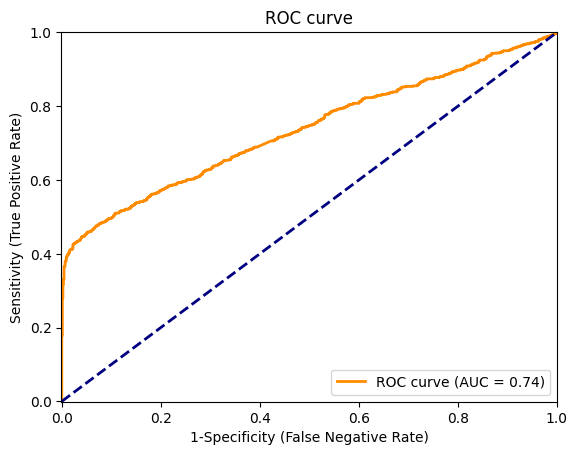

 Optimal threshold:  0.7112979457890221
 AUC: 0.7351195357156044


In [34]:
# use the fitted model to predict the testing data
y_pred_prob = Classifier_SVM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Support Vector Machines model: \n')

cm_1 = [confusion_matrix(y_test, y_pred)[1][1],confusion_matrix(y_test, y_pred)[0][1]]
cm_2 = [confusion_matrix(y_test, y_pred)[1][0],confusion_matrix(y_test, y_pred)[0][0]]
print("Confusion matrix: \n" + str(cm_1) + "\n" + str(cm_2))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))